# 클러스터링을 통한 고객 충성도 강화 프로젝트

In [441]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터셋 불러오기

In [442]:
orders = pd.read_csv('C:/Users/pyj66/Downloads/archive (1)/orders.csv')
order_items = pd.read_csv('C:/Users/pyj66/Downloads/archive (1)/order_items.csv')
customers = pd.read_csv('C:/Users/pyj66/Downloads/archive (1)/customers.csv')
payments = pd.read_csv('C:/Users/pyj66/Downloads/archive (1)/payments.csv')
products = pd.read_csv('C:/Users/pyj66/Downloads/archive (1)/products.csv')

In [443]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,10/2/2017 10:56,10/2/2017 11:07,10/10/2017 21:25,10/18/2017 0:00
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,7/24/2018 20:41,7/26/2018 3:24,8/7/2018 15:27,8/13/2018 0:00
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,8/8/2018 8:38,8/8/2018 8:55,8/17/2018 18:06,9/4/2018 0:00
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,delivered,11/18/2017 19:28,11/18/2017 19:45,12/2/2017 0:28,12/15/2017 0:00
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2/13/2018 21:18,2/13/2018 22:20,2/16/2018 18:17,2/26/2018 0:00


In [444]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,price,shipping_charges
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14


In [445]:
customers.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [446]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [447]:
products.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,625.0,20.0,17.0,13.0


### customers 테이블 중복값 제거 후, 병합

In [448]:
print(len(customers))
print(len(set(customers['customer_id'])))

# 고객당 하나의 아이디만 남기기 위해 customer_id 기준으로 중복값 제거
customers = customers.groupby('customer_id').first().reset_index()

99441
96096


In [449]:
# 고객과 관련된 모든 정보를 체계적으로 정리하기 위해 다음과 같이 병합합

df = pd.merge(customers, orders, on='customer_id', how='left')
df = pd.merge(df, payments, on='order_id', how='left')
df = pd.merge(df, order_items, on='order_id', how='left')
df = pd.merge(df, products, on='product_id', how='left')

### 이상치 처리

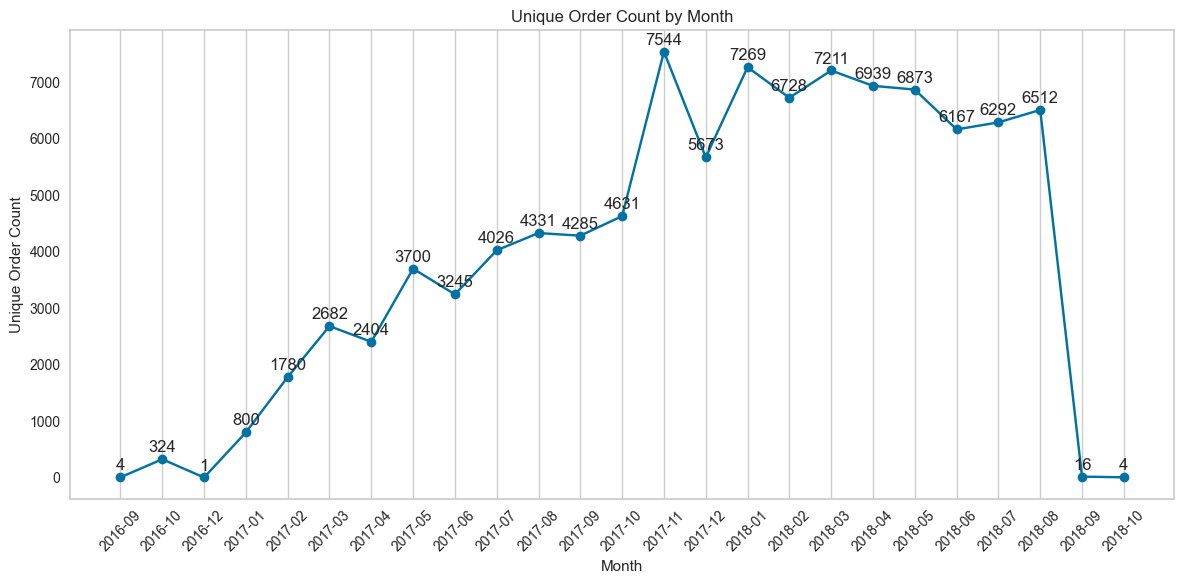

In [450]:
# order_purchase_timestamp를 날짜 형식으로 변환
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# 연도-월 추출
df['year_month'] = df['order_purchase_timestamp'].dt.to_period('M')

# 연도-월 별 order_id 고유 개수 계산
monthly_order_counts = df.groupby('year_month')['order_id'].nunique().reset_index()

# 'year_month'를 문자열로 변환하여 x축에 사용
monthly_order_counts['year_month_str'] = monthly_order_counts['year_month'].astype(str)

# 월별 order_id 고유 개수 시각화
plt.figure(figsize=(12, 6))
plt.plot(monthly_order_counts['year_month_str'], monthly_order_counts['order_id'], marker='o', linestyle='-', color='b')

# 데이터 포인트 값 표시
for i, txt in enumerate(monthly_order_counts['order_id']):
    plt.annotate(f'{txt}', (monthly_order_counts['year_month_str'][i], monthly_order_counts['order_id'][i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel('Month')
plt.ylabel('Unique Order Count')
plt.title('Unique Order Count by Month')
plt.xticks(rotation=45)

# 가로 그리드만 추가
plt.grid(axis='y')

plt.tight_layout()
plt.show()

##### 2016년초와 2018년9월의데이터수가 0~3개로 데이터수집과정에서 오류가발생했다고판단하여 2017년~2018년8월의데이터만사용

In [451]:
# 데이터 필터링: 2017년 1월 ~ 2018년 8월
start_date = '2017-01-01'
end_date = '2018-08-31'
df = df[(df['order_purchase_timestamp'] >= start_date) & (df['order_purchase_timestamp'] <= end_date)]

### 결측치 처리

In [452]:
# 각 열의 결측치 개수 계산
missing_values_count = df.isnull().sum()

# 결측치가 있는 열과 그 개수 출력
print(missing_values_count[missing_values_count > 0])

order_approved_at             150
order_delivered_timestamp    3311
order_item_id                 793
product_id                    793
seller_id                     793
price                         793
shipping_charges              793
product_category_name        1224
product_weight_g              813
product_length_cm             813
product_height_cm             813
product_width_cm              813
dtype: int64


##### 'order_item_id', 'product_id', 'seller_id', 'price', 'shipping_charges' 모두 동일행에서 결측치 존재하지 않는지 확인

In [453]:
# 결측치가 없는 행 필터링
not_null = df[df[['order_item_id', 'product_id', 'seller_id', 'price', 'shipping_charges']].notnull().all(axis=1)]

len(df)==len(not_null)+df['order_item_id'].isnull().sum()

True

In [454]:
# order_item_id가 결측치인 행 제거
df = df.dropna(subset=['order_item_id'])

In [455]:
#  결측치를 'Others'로 변경
df['product_category_name'].fillna('Others', inplace=True)

# 배송 시간 계산의 필수 요소이기 때문에 결측치 행 제거 처리
df = df.dropna(subset=['order_delivered_timestamp','order_approved_at'])

In [456]:
# 각 열의 결측치 개수 계산
missing_values_count = df.isnull().sum()

# 결측치가 있는 열과 그 개수 출력
print(missing_values_count[missing_values_count > 0])

product_weight_g     20
product_length_cm    20
product_height_cm    20
product_width_cm     20
dtype: int64


In [457]:
# 상품 사이즈 관련 결측치 제거
df = df.dropna(subset=['product_category_name','product_weight_g','product_length_cm','product_height_cm','product_width_cm'], how='any')

### 파생 변수 생성

In [458]:
# order_delivered_timestamp datetime으로 변환
df['order_delivered_timestamp'] = pd.to_datetime(df['order_delivered_timestamp'], format='%m/%d/%Y %H:%M', errors='coerce')

# 배송 예정 시간도 datetime으로 변환
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'], format='%m/%d/%Y %H:%M', errors='coerce')

# 배송 시간 칼럼 생성
df['delivery_time'] = (df['order_delivered_timestamp'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600

# 지연 시간 계산 (날짜 단위)
df['delay_time'] = (df['order_delivered_timestamp'] - df['order_estimated_delivery_date']).dt.days

# 파생변수 volume 생성 (가로 * 세로 * 높이)
df['volume'] = df['product_height_cm'] * df['product_length_cm'] * df['product_width_cm']

In [459]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114662 entries, 0 to 118433
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    114662 non-null  object        
 1   customer_zip_code_prefix       114662 non-null  int64         
 2   customer_city                  114662 non-null  object        
 3   customer_state                 114662 non-null  object        
 4   order_id                       114662 non-null  object        
 5   order_status                   114662 non-null  object        
 6   order_purchase_timestamp       114662 non-null  datetime64[ns]
 7   order_approved_at              114662 non-null  object        
 8   order_delivered_timestamp      114662 non-null  datetime64[ns]
 9   order_estimated_delivery_date  114662 non-null  datetime64[ns]
 10  payment_sequential             114662 non-null  float64       
 11  payme

In [460]:
df.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,...,shipping_charges,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,year_month,delivery_time,delay_time,volume
0,0000366f3b9a7992bf8c76cfdf3221e2,7787,cajamar,SP,e22acc9c116caa3f2b7121bbb380d08e,delivered,2018-05-10 10:56:00,5/10/2018 11:11,2018-05-16 20:48:00,2018-05-21,...,12.00,toys,1500.0,34.0,7.0,32.0,2018-05,153.866667,-5,7616.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,osasco,SP,3594e05a005ac4d06a72673270ef9ec9,delivered,2018-05-07 11:11:00,5/7/2018 18:25,2018-05-10 18:02:00,2018-05-15,...,8.29,health_beauty,375.0,26.0,11.0,18.0,2018-05,78.850000,-5,5148.0
2,0000f46a3911fa3c0805444483337064,88115,sao jose,SC,b33ec3b699337181488304f362a6b734,delivered,2017-03-10 21:05:00,3/10/2017 21:05,2017-04-05 14:38:00,2017-04-07,...,17.22,toys,1500.0,25.0,50.0,35.0,2017-03,617.550000,-2,43750.0
3,0000f6ccb0745a6a4b88665a16c9f078,66812,belem,PA,41272756ecddd9a9ed0180413cc22fb6,delivered,2017-10-12 20:29:00,10/12/2017 20:49,2017-11-01 21:23:00,2017-11-13,...,17.63,toys,150.0,19.0,5.0,11.0,2017-10,480.900000,-12,1045.0
4,0004aac84e0df4da2b147fca70cf8255,18040,sorocaba,SP,d957021f1127559cd947b62533f484f7,delivered,2017-11-14 19:45:00,11/14/2017 20:06,2017-11-27 23:08:00,2017-12-05,...,16.89,toys,6050.0,16.0,3.0,11.0,2017-11,315.383333,-8,528.0


### 클러스터링을 위한 인코딩

In [461]:
print(len(set(df['customer_state'])))
print(len(set(df['payment_type'])))
print(len(set(df['product_category_name'])))

27
4
70


##### 라벨 인코딩으로 결정: 데이터 종류가 적어 순서 기반 문제 발생 가능성이 적고, 원핫보다 효율적. 거리 기반 알고리즘과의 호환성도 높음

In [462]:
# customer_state 5개 지역으로 그룹화
state_groups = {
    'Southern ': ['RS', 'SC', 'PR'],
    'Southeast  ': ['SP', 'RJ', 'MG', 'ES'],
    'Central ': ['DF', 'GO', 'MT', 'MS'],
    'Northern': ['AM', 'PA', 'TO', 'RR', 'AP', 'RO', 'AC'],
    'Northeast ': ['BA', 'CE', 'PE', 'MA', 'PB', 'RN', 'AL', 'SE', 'PI']
}
# customer_state를 그룹에 매핑하는 함수 정의
def map_to_group(state):
    for group, states in state_groups.items():
        if state in states:
            return group
    return 'Others'  # 예외 처리: 그룹에 속하지 않는 경우
# 새로운 컬럼 추가
df['customer_state_en'] = df['customer_state'].apply(map_to_group)

# LabelEncoder 객체 생성 및 적용
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['customer_state_en'] = label_encoder.fit_transform(df['customer_state_en'])

# payment_type -> 인코딩
le = LabelEncoder()
df['payment_type_en'] = le.fit_transform(df['payment_type'])


In [463]:
category_counts = df['product_category_name'].value_counts()
print(category_counts)

product_category_name
toys                                 86094
health_beauty                         3033
bed_bath_table                        2688
sports_leisure                        2327
computers_accessories                 2204
                                     ...  
fashion_sport                            4
fashion_childrens_clothes                2
furniture_mattress_and_upholstery        1
security_and_services                    1
home_comfort_2                           1
Name: count, Length: 70, dtype: int64


In [464]:
# 새로운 분류를 저장할 리스트 생성
temp = []

# product_category_name에 따라 분류
for category in df['product_category_name']:
    if category == 'toys':
        temp.append('toy')
    else:
        temp.append('non-toy')

# 새로운 분류 결과를 DataFrame에 추가
df['toy/non-toy'] = temp

In [465]:
temp = []
for category in df['product_category_name']:
    if category in ('computers_accessories', 'telephony', 'electronics', 
                    'computers', 'home_appliances', 'small_appliances_home_oven_and_coffee', 
                    'tablets_printing_image', 'audio', 'dvds_blu_ray', 'fixed_telephony', 
                    'air_conditioning', 'cine_photo', 'industry_commerce_and_business'):
        temp.append('Electronics_Appliances')
    elif category in ('watches_gifts', 'fashion_bags_accessories', 'fashion_underwear_beach', 
                      'fashion_female_clothing', 'fashion_shoes', 'fashion_sport', 
                      'health_beauty', 'fashion_male_clothing', 'fashion_childrens_clothes', 
                      'perfumery'):
        temp.append('Fashion_Beauty')
    elif category in ('bed_bath_table', 'furniture_decor', 'furniture_living_room', 
                      'home_comfort_2', 'furniture_bedroom', 'furniture_mattress_and_upholstery', 
                      'kitchen_dining_laundry_garden_furniture', 'home_confort', 'housewares', 
                      'home_construction', 'garden_tools', 'home_appliances_2'):
        temp.append('Furniture_Home_Goods')
    elif category in ('sports_leisure', 'cool_stuff', 'musical_instruments', 'art', 
                      'party_supplies', 'books_general_interest', 'consoles_games', 
                      'arts_and_craftmanship', 'market_place', 'christmas_supplies'):
        temp.append('Hobbies_Entertainment')
    elif category in ('toys'):
        temp.append('toy')
    else:
        temp.append('Other')

df['product_category_group'] = temp

In [466]:
# 각 'product_category_group' 값의 개수를 계산
category_counts = df['product_category_group'].value_counts()
category_counts

product_category_group
toy                       86094
Furniture_Home_Goods       8175
Fashion_Beauty             5993
Other                      5463
Electronics_Appliances     4919
Hobbies_Entertainment      4018
Name: count, dtype: int64

In [467]:
# 결측값이 있는 행 삭제
df_cleaned = df.dropna()

# 라벨 인코딩
label_encoder = LabelEncoder()
df_cleaned['product_category_group_en'] = label_encoder.fit_transform(df_cleaned['product_category_group'])

### 분석 및 시각화에서 사용하기 위해, 인코딩 하기 전 칼럼도 남겨둠

In [468]:
df_cleaned.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,...,product_width_cm,year_month,delivery_time,delay_time,volume,customer_state_en,payment_type_en,toy/non-toy,product_category_group,product_category_group_en
0,0000366f3b9a7992bf8c76cfdf3221e2,7787,cajamar,SP,e22acc9c116caa3f2b7121bbb380d08e,delivered,2018-05-10 10:56:00,5/10/2018 11:11,2018-05-16 20:48:00,2018-05-21,...,32.0,2018-05,153.866667,-5,7616.0,3,0,toy,toy,5
1,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,osasco,SP,3594e05a005ac4d06a72673270ef9ec9,delivered,2018-05-07 11:11:00,5/7/2018 18:25,2018-05-10 18:02:00,2018-05-15,...,18.0,2018-05,78.850000,-5,5148.0,3,0,non-toy,Fashion_Beauty,1
2,0000f46a3911fa3c0805444483337064,88115,sao jose,SC,b33ec3b699337181488304f362a6b734,delivered,2017-03-10 21:05:00,3/10/2017 21:05,2017-04-05 14:38:00,2017-04-07,...,35.0,2017-03,617.550000,-2,43750.0,4,0,toy,toy,5
3,0000f6ccb0745a6a4b88665a16c9f078,66812,belem,PA,41272756ecddd9a9ed0180413cc22fb6,delivered,2017-10-12 20:29:00,10/12/2017 20:49,2017-11-01 21:23:00,2017-11-13,...,11.0,2017-10,480.900000,-12,1045.0,2,0,toy,toy,5
4,0004aac84e0df4da2b147fca70cf8255,18040,sorocaba,SP,d957021f1127559cd947b62533f484f7,delivered,2017-11-14 19:45:00,11/14/2017 20:06,2017-11-27 23:08:00,2017-12-05,...,11.0,2017-11,315.383333,-8,528.0,3,0,toy,toy,5


In [469]:
# # DataFrame을 CSV 파일로 내보내기
# df_cleaned.to_csv('최종_0808.csv', index=False)

### 전반적인 매출 추세 및 고객수 확인

##### customer_id 별 집계

In [470]:
df_cleaned.columns

Index(['customer_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_timestamp', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'order_item_id', 'product_id', 'seller_id', 'price',
       'shipping_charges', 'product_category_name', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'year_month', 'delivery_time', 'delay_time', 'volume',
       'customer_state_en', 'payment_type_en', 'toy/non-toy',
       'product_category_group', 'product_category_group_en'],
      dtype='object')

##### 매출 추세

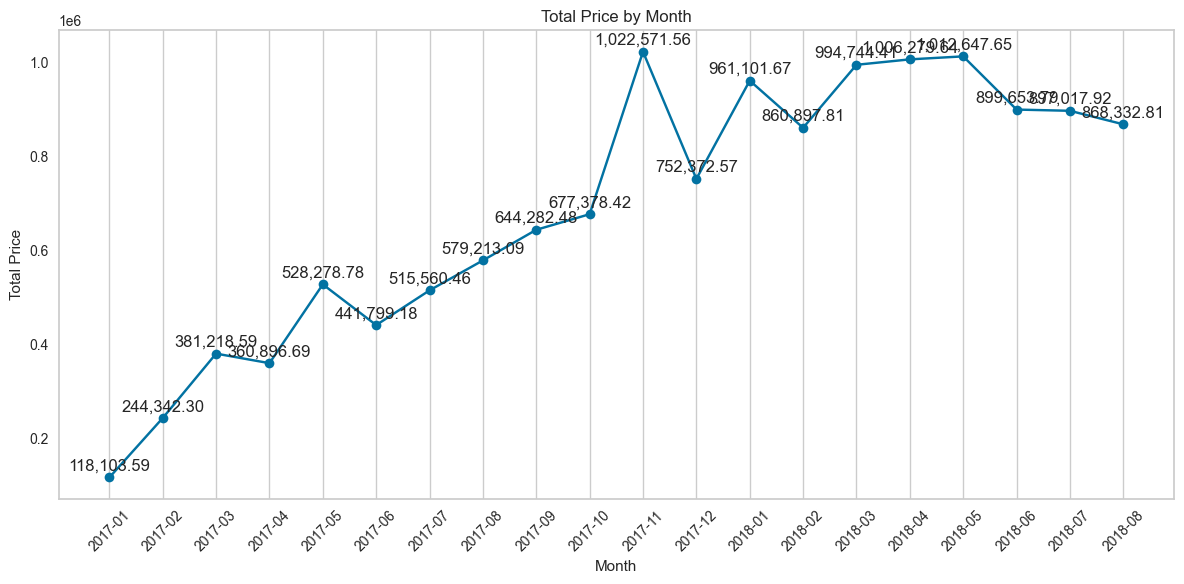

In [471]:
# order_purchase_timestamp를 날짜 형식으로 변환
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# 연도-월 추출
df['year_month'] = df['order_purchase_timestamp'].dt.to_period('M')

# 연도-월 별 price 총합 계산
monthly_totals = df.groupby('year_month')['price'].sum().reset_index()

# 'year_month'를 문자열로 변환하여 x축에 사용
monthly_totals['year_month_str'] = monthly_totals['year_month'].astype(str)

# 월별 price 총합 시각화
plt.figure(figsize=(12, 6))
plt.plot(monthly_totals['year_month_str'], monthly_totals['price'], marker='o', linestyle='-', color='b')

# 데이터 포인트 값 표시
for i, txt in enumerate(monthly_totals['price']):
    plt.annotate(f'{txt:,.2f}', (monthly_totals['year_month_str'][i], monthly_totals['price'][i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel('Month')
plt.ylabel('Total Price')
plt.title('Total Price by Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### 고유 고객수

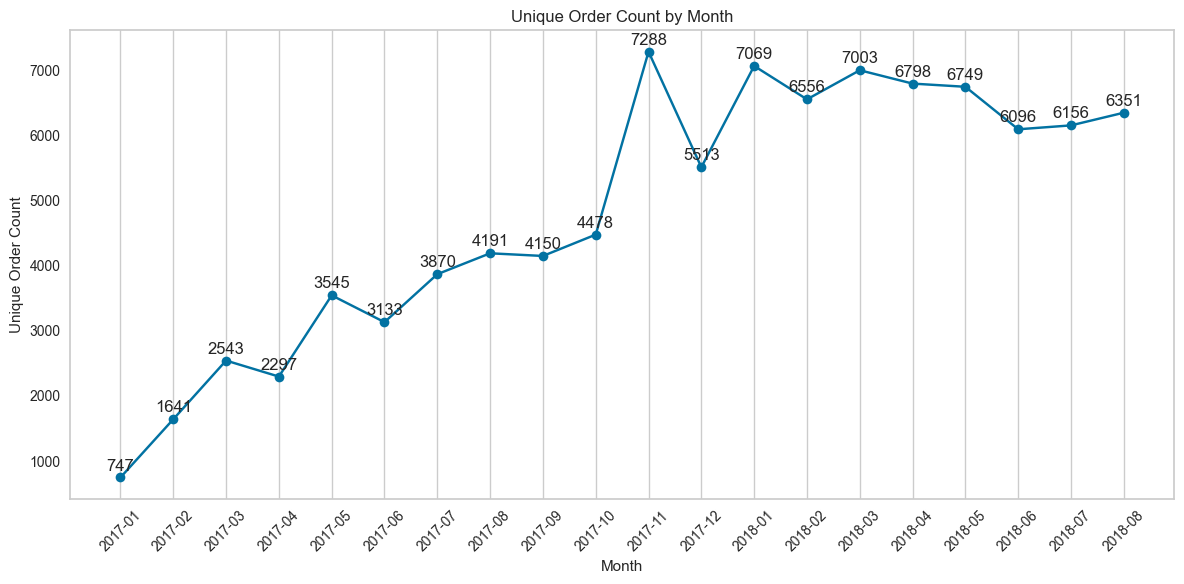

In [472]:
# order_purchase_timestamp를 날짜 형식으로 변환
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# 연도-월 추출
df['year_month'] = df['order_purchase_timestamp'].dt.to_period('M')

# 연도-월 별 order_id 고유 개수 계산
monthly_order_counts = df.groupby('year_month')['order_id'].nunique().reset_index()

# 'year_month'를 문자열로 변환하여 x축에 사용
monthly_order_counts['year_month_str'] = monthly_order_counts['year_month'].astype(str)

# 월별 order_id 고유 개수 시각화
plt.figure(figsize=(12, 6))
plt.plot(monthly_order_counts['year_month_str'], monthly_order_counts['order_id'], marker='o', linestyle='-', color='b')

# 데이터 포인트 값 표시
for i, txt in enumerate(monthly_order_counts['order_id']):
    plt.annotate(f'{txt}', (monthly_order_counts['year_month_str'][i], monthly_order_counts['order_id'][i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel('Month')
plt.ylabel('Unique Order Count')
plt.title('Unique Order Count by Month')
plt.xticks(rotation=45)

# 가로 그리드만 추가
plt.grid(axis='y')

plt.tight_layout()
plt.show()

##### 코호트 분석

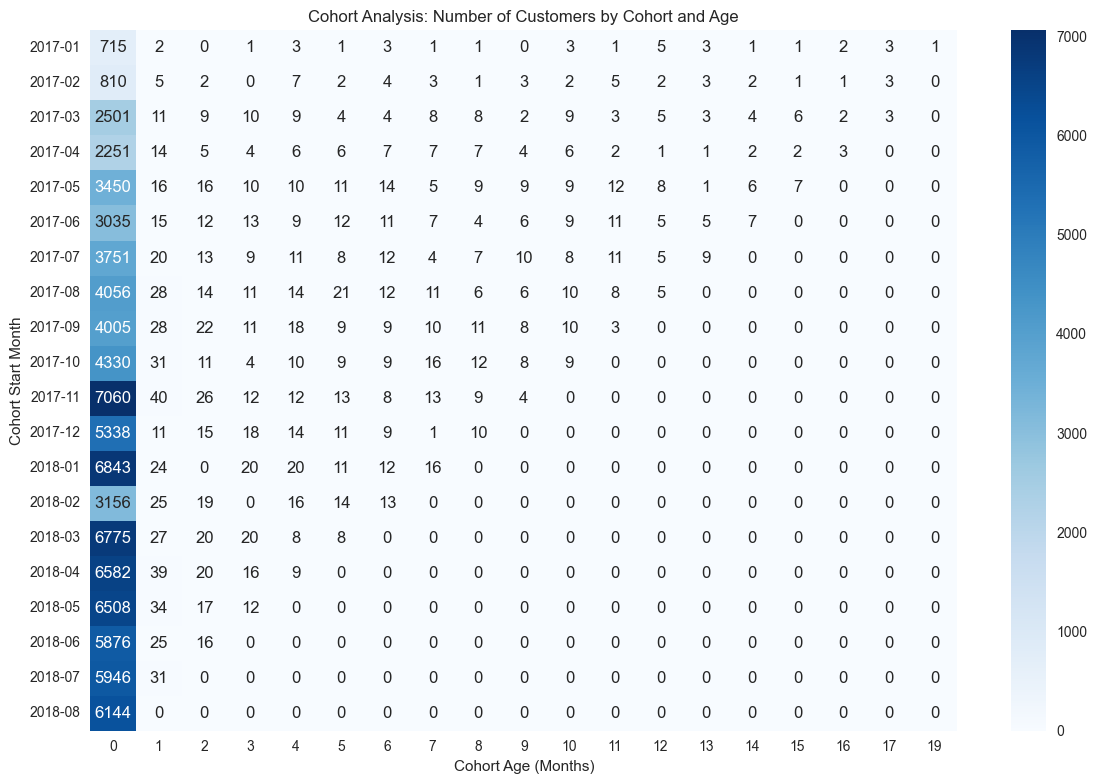

In [473]:
# 'order_purchase_timestamp'를 날짜 형식으로 변환
df_cleaned['order_purchase_timestamp'] = pd.to_datetime(df_cleaned['order_purchase_timestamp'])

# 고객별 첫 구매 월 추출
df_cleaned['first_purchase_month'] = df_cleaned.groupby('customer_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
df_cleaned['order_month'] = df_cleaned['order_purchase_timestamp'].dt.to_period('M')

# 코호트 데이터 생성
cohort_data = df_cleaned.groupby(['first_purchase_month', 'order_month']).agg(
    num_customers=('customer_id', 'nunique')
).reset_index()

# 코호트 연령 추가 (개월 단위)
cohort_data['cohort_age'] = (
    cohort_data['order_month'].astype('datetime64').astype('int64') -
    cohort_data['first_purchase_month'].astype('datetime64').astype('int64')
) // 10**9 // (30*24*60*60)  # Convert seconds to months

# 피벗 테이블로 변환
cohort_pivot = cohort_data.pivot_table(
    index='first_purchase_month',
    columns='cohort_age',
    values='num_customers'
).fillna(0)

# 코호트 분석 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='Blues', cbar=True)
plt.title('Cohort Analysis: Number of Customers by Cohort and Age')
plt.xlabel('Cohort Age (Months)')
plt.ylabel('Cohort Start Month')
plt.tight_layout()
plt.show()


##### 재구매율

In [474]:
# 고객별 첫 방문일을 가입일로 설정
df_cleaned['signup_month'] = df_cleaned.groupby('customer_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')

# 방문 월
df_cleaned['visit_month'] = df_cleaned['order_purchase_timestamp'].dt.to_period('M')

# 가입 월별 고객 수
signup_counts = df_cleaned.groupby('signup_month')['customer_id'].nunique()

# 가입 월별 재방문한 고객 수 (재방문 여부를 확인하기 위해)
# 재방문한 고객은 가입 월과 다른 방문 월을 가진 경우
revisit_customers = df_cleaned[df_cleaned['signup_month'] != df_cleaned['visit_month']]
revisit_counts = revisit_customers.groupby('signup_month')['customer_id'].nunique()

# 재방문율 계산
revisit_rate = (revisit_counts / signup_counts).fillna(0) * 100

print("재방문율:")
print(revisit_rate)

# 이탈률 계산
# 이탈률: 가입 월 이후 특정 기간 동안 방문하지 않은 고객 비율
# 가입 월 이후 방문한 적 없는 고객 수를 찾습니다.
def calculate_churn_rate(signup_customers, revisit_customers):
    churned = len(signup_customers - revisit_customers)
    return (churned / len(signup_customers)) * 100

# 가입 월별 고객 목록
all_customers = df_cleaned.groupby('signup_month')['customer_id'].unique()

# 가입 월별 재방문 고객 목록
revisit_customers = df_cleaned[df_cleaned['signup_month'] != df_cleaned['visit_month']].groupby('signup_month')['customer_id'].unique()

churn_rates = {}
for month, customers in all_customers.items():
    if month in revisit_customers:
        churn_rate = calculate_churn_rate(set(customers), set(revisit_customers[month]))
    else:
        churn_rate = 100
    churn_rates[month] = churn_rate

print("이탈률:")
print(pd.Series(churn_rates))

재방문율:
signup_month
2017-01    4.195804
2017-02    2.784653
2017-03    3.438625
2017-04    3.376277
2017-05    3.536232
2017-06    3.591433
2017-07    3.092509
2017-08    3.180473
2017-09    3.021223
2017-10    2.494226
2017-11    1.883853
2017-12    1.629824
2018-01    1.739003
2018-02    1.685483
2018-03    1.180812
2018-04    1.245822
2018-05    0.952674
2018-06    0.680735
2018-07    0.521359
2018-08    0.000000
Freq: M, Name: customer_id, dtype: float64
이탈률:
2017-01     95.804196
2017-02     97.215347
2017-03     96.561375
2017-04     96.623723
2017-05     96.463768
2017-06     96.408567
2017-07     96.907491
2017-08     96.819527
2017-09     96.978777
2017-10     97.505774
2017-11     98.116147
2017-12     98.370176
2018-01     98.260997
2018-02     98.314517
2018-03     98.819188
2018-04     98.754178
2018-05     99.047326
2018-06     99.319265
2018-07     99.478641
2018-08    100.000000
Freq: M, dtype: float64


In [475]:
# 고객별로 첫 번째 구매 날짜와 구매 횟수를 계산
df_cleaned['purchase_count'] = df_cleaned.groupby('customer_id')['order_purchase_timestamp'].cumcount() + 1

# 두 번 이상 구매한 고객 식별 (동일 날짜 제외)
repeat_customers = df_cleaned[df_cleaned['purchase_count'] > 1].drop_duplicates(subset=['customer_id', 'order_purchase_timestamp'])

# 재구매 고객 수 계산
num_repeat_customers = repeat_customers['customer_id'].nunique()

# 전체 고객 수 계산
total_customers = df_cleaned['customer_id'].nunique()

# 전체 재구매율 계산
repeat_rate = num_repeat_customers / total_customers

print(f"전체 고객 재구매율: {repeat_rate:.2%}")

전체 고객 재구매율: 15.01%


##### 신규 방문자수

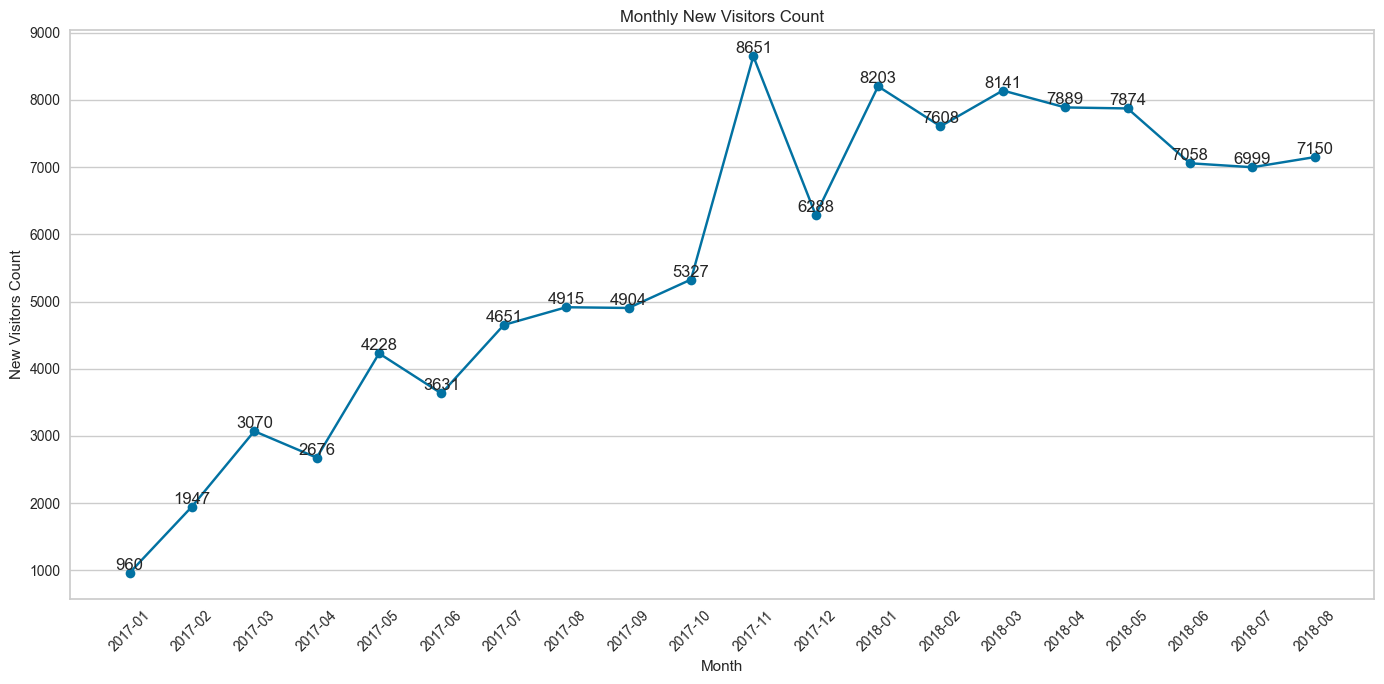

In [476]:
import pandas as pd
import matplotlib.pyplot as plt

# 날짜 형식으로 변환
df_cleaned['order_purchase_timestamp'] = pd.to_datetime(df_cleaned['order_purchase_timestamp'])

# 신규 방문자 수 계산을 위해 첫 방문일을 추출
df_cleaned['first_visit_date'] = df_cleaned.groupby('customer_id')['order_purchase_timestamp'].transform('min')

# 신규 방문자 수 계산: 월별로 첫 방문일이 같은 고객 수를 계산
df_cleaned['month'] = df_cleaned['order_purchase_timestamp'].dt.to_period('M')
df_cleaned['first_visit_month'] = df_cleaned['first_visit_date'].dt.to_period('M')

# 월별 신규 방문자 수 계산
monthly_new_visitors = df_cleaned[df_cleaned['month'] == df_cleaned['first_visit_month']]
monthly_new_visitors_counts = monthly_new_visitors.groupby('month').size().reset_index(name='new_visitors_count')

# 월 단위로 변환
monthly_new_visitors_counts['month'] = monthly_new_visitors_counts['month'].astype(str)

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(monthly_new_visitors_counts['month'], monthly_new_visitors_counts['new_visitors_count'], linestyle='-', color='b', marker='o')

# 값 표시
for i, row in monthly_new_visitors_counts.iterrows():
    plt.text(row['month'], row['new_visitors_count'], row['new_visitors_count'], ha='center', va='bottom')

plt.xlabel('Month')
plt.ylabel('New Visitors Count')
plt.title('Monthly New Visitors Count')
plt.xticks(rotation=45)
plt.grid(axis='x')  # 가로 그리드만 추가
plt.tight_layout()
plt.show()


### 클러스터링

##### customer_id 를 기준으로 데이터 집계

In [477]:
# 고객별로 필요한 특성들을 집계
df_agg = df_cleaned.groupby('customer_id').agg({
    'order_id': 'count',  # 주문 횟수
    'payment_value': 'sum', # 총 거래 금액 합계
    'price': 'sum',  # 총 상품 금액 평균
    'shipping_charges': 'sum',  # 총 배송비 평균
    'product_category_group_en': lambda x: x.mode()[0],  # 상품 종류 최빈값
    'product_weight_g': 'mean',  # 상품 무게 평균
    'volume': 'mean',  # 상품 부피 평균
    'delay_time': 'mean',  # 평균 배송 지연
    'customer_state_en': 'first',  # 고객의 주 소 위치 (첫 번째 값)
    'payment_type_en': lambda x: x.mode()[0],  # 최빈값 결제 방법,
    'product_id': lambda x: x.nunique(), # 유니크한 상품의 수,
    'seller_id': lambda x: x.nunique() # 유니크한 판매자 수
}).reset_index()

# customer_id를 제외한 나머지 컬럼 선택
columns_to_keep = df_agg.columns.difference(['customer_id'])

# 선택된 컬럼으로 데이터프레임 재구성
df_clust = df_agg[columns_to_keep]
df_clust

,customer_state_en,delay_time,order_id,payment_type_en,payment_value,price,product_category_group_en,product_id,product_weight_g,seller_id,shipping_charges,volume
0,3,-5.0,1,0,141.90,129.90,5,1,1500.0,1,12.00,7616.0
1,3,-5.0,1,0,27.19,18.90,1,1,375.0,1,8.29,5148.0
2,4,-2.0,1,0,86.22,69.00,5,1,1500.0,1,17.22,43750.0
3,2,-12.0,1,0,43.62,25.99,5,1,150.0,1,17.63,1045.0
4,3,-8.0,1,0,196.89,180.00,5,1,6050.0,1,16.89,528.0
...,...,...,...,...,...,...,...,...,...,...,...,...
93066,1,-27.0,2,0,4134.84,1570.00,1,2,30000.0,1,497.42,251625.0
93067,1,-3.0,1,0,84.58,64.89,5,1,1720.0,1,19.69,32076.0
93068,0,-30.0,1,0,112.46,89.90,5,1,600.0,1,22.56,3315.0
93069,3,-14.0,1,0,133.69,115.00,5,1,444.0,1,18.69,4480.0


##### feature 설정

In [478]:
# payment value 만 제거
features1 = [
    'order_id', 
    'price', 
    'shipping_charges', 
    'product_category_group_en', 
    'product_weight_g', 
    'volume', 
    'delay_time', 
    'customer_state_en', 
    'payment_type_en'
]
df_clust1=df_clust[features1]
# price, shipping_charges 둘만 제거
features2 = [
    'order_id', 
    'payment_value', 
    'product_category_group_en', 
    'product_weight_g', 
    'volume', 
    'delay_time', 
    'customer_state_en', 
    'payment_type_en'
]
df_clust2=df_clust[features2]

# 주요 지표들만 추리기
features3=[
    'order_id', 
    'payment_value',
    'product_category_group_en', 
    'customer_state_en', 
]
df_clust3=df_clust[features3]

# 주요 지표들만 추리기 ->payment를 다른 두 값으로 대체
features4=[
    'order_id', 
    'price', 
    'shipping_charges', 
    'product_category_group_en', 
    'customer_state_en'
]
df_clust4=df_clust[features4]

# 로그화 진행
import numpy as np
# 로그 변환
df_log=df_clust.copy()
df_log['log_price'] = np.log1p(df_clust['price'])
df_log['log_product_weight_g'] = np.log1p(df_clust['product_weight_g'])
df_log['log_shipping_charges'] = np.log1p(df_clust['shipping_charges'])
df_log['log_payment_value'] = np.log1p(df_clust['payment_value'])
df_log['log_volume'] = np.log1p(df_clust['volume'])

features5=[
    'order_id', 
    'log_price', 
    'log_shipping_charges', 
    'product_category_group_en', 
    'customer_state_en', 
]
df_clust5=df_log[features5]

features6=[
    'order_id', 
    'log_price', 
    'log_shipping_charges', 
    'product_category_group_en', 
    'log_product_weight_g', 
    'log_volume', 
    'delay_time', 
    'customer_state_en', 
    'payment_type_en'
]
df_clust6=df_log[features6]

features7=[
    'order_id', 
    'price',
    'shipping_charges'
]
df_clust7=df_clust[features7]

features8=[
    'order_id', 
    'payment_value',
    'price', 
    'shipping_charges', 
    'product_category_group_en', 
    'product_weight_g', 
    'volume', 
    'delay_time', 
    'customer_state_en', 
    'payment_type_en'
]
df_clust8=df_log[features8]

features9=[
    'order_id', 
    'log_price', 
    'log_shipping_charges', 
    'product_category_group_en', 
    'delay_time', 
    'customer_state_en'
]
df_clust9=df_log[features9]


##### 스케일링 설정

In [479]:
# 모두 동일하게 스케일링

# import pandas as pd
# from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer
# from sklearn.preprocessing import StandardScaler

# # 데이터 준비
# clustering = df_clust4  # 클러스터링에 사용할 데이터셋
# features = features4  # 클러스터링에 사용할 피처

# # 피처 데이터를 클러스터링에 사용될 형식으로 준비
# X = clustering[features]

# # 스케일링 (표준화)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # KMeans 모델을 정의하고 Elbow 방법을 사용해 최적의 K를 찾습니다.
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(2,12))

# # 피팅 및 시각화
# visualizer.fit(X_scaled)
# visualizer.show()

In [480]:
# 범주형 제외 스케일링(표준화)

# import pandas as pd
# from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer
# from sklearn.preprocessing import StandardScaler

# # 데이터 준비
# clustering = df_clust4  # 클러스터링에 사용할 데이터셋
# features = features4  # 클러스터링에 사용할 피처

# # 스케일링에서 제외할 피처
# features_to_exclude = ['product_category_group_en', 'customer_state_en']

# # 스케일링할 피처만 선택
# features_to_scale = [feature for feature in features if feature not in features_to_exclude]

# # 스케일링 제외 피처와 스케일링할 피처 데이터 분리
# X_to_scale = clustering[features_to_scale]
# X_excluded = clustering[features_to_exclude]

# # 스케일링 (표준화)
# scaler = StandardScaler()
# X_scaled_2 = scaler.fit_transform(X_to_scale)

# # 스케일링된 데이터프레임을 다시 만듭니다.
# X_scaled_df = pd.DataFrame(X_scaled_2, columns=features_to_scale, index=clustering.index)

# # 스케일링 제외 피처와 결합
# X_scaled = pd.concat([X_scaled_df, X_excluded], axis=1)

# # KMeans 모델을 정의하고 Elbow 방법을 사용해 최적의 K를 찾습니다.
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(2,12))

# # 피팅 및 시각화
# visualizer.fit(X_scaled)
# visualizer.show()


In [481]:
# # 모두 동일하게, minmax

# import pandas as pd
# from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

# # 데이터 준비
# clustering = df_clust4  # 클러스터링에 사용할 데이터셋
# features = features4  # 클러스터링에 사용할 피처

# # 피처 데이터를 클러스터링에 사용될 형식으로 준비
# X = clustering[features]

# # 스케일링 (MinMax)
# scaler = MinMaxScaler()  # MinMaxScaler 사용
# X_scaled = scaler.fit_transform(X)


# # KMeans 모델을 정의하고 Elbow 방법을 사용해 최적의 K를 찾습니다.
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(2,12))

# # 피팅 및 시각화
# visualizer.fit(X_scaled)
# visualizer.show()

##### 실루엣 계수가 가장 높은 아래 조건 선택

c:\Users\pyj66\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pyj66\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pyj66\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pyj66\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\

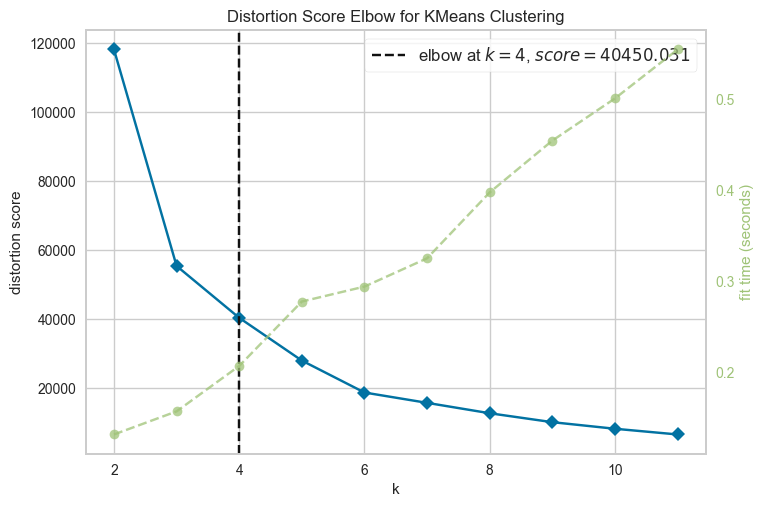

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [482]:
# 범주형 제외, minmax

import pandas as pd
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler  # MinMaxScaler로 변경

# 데이터 준비
clustering = df_clust4  # 클러스터링에 사용할 데이터셋
features = features4  # 클러스터링에 사용할 피처

# 스케일링에서 제외할 피처
features_to_exclude = ['product_category_group_en', 'customer_state_en']

# 스케일링할 피처만 선택
features_to_scale = [feature for feature in features if feature not in features_to_exclude]

# 스케일링 제외 피처와 스케일링할 피처 데이터 분리
X_to_scale = clustering[features_to_scale]
X_excluded = clustering[features_to_exclude]

# 스케일링 (MinMax)
scaler = MinMaxScaler()  # MinMaxScaler 사용
X_scaled_2 = scaler.fit_transform(X_to_scale)

# 스케일링된 데이터프레임을 다시 만듭니다.
X_scaled_df = pd.DataFrame(X_scaled_2, columns=features_to_scale, index=clustering.index)

# 스케일링 제외 피처와 결합
X_scaled = pd.concat([X_scaled_df, X_excluded], axis=1)

# KMeans 모델을 정의하고 Elbow 방법을 사용해 최적의 K를 찾습니다.
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))

# 피팅 및 시각화
visualizer.fit(X_scaled)
visualizer.show()


In [483]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 최적의 K값 4를 참고하여 3으로 조정
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k)
clusters = kmeans.fit_predict(X_scaled)

# 클러스터링 결과를 DataFrame에 추가
df_clust['cluster'] = clusters
df_clust4['cluster'] = clusters

c:\Users\pyj66\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_30976\3840449479.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust4['cluster'] = clusters


In [484]:
from sklearn.metrics import silhouette_score

# 실루엣 계수 계산
silhouette_avg = silhouette_score(X_scaled, df_clust['cluster'])
print(f"Average Silhouette Score: {silhouette_avg:.2f}")

Average Silhouette Score: 0.75


In [485]:
from sklearn.metrics import silhouette_samples

# 실루엣 점수 계산
silhouette_vals = silhouette_samples(X_scaled, df_clust['cluster'])

### 시각화

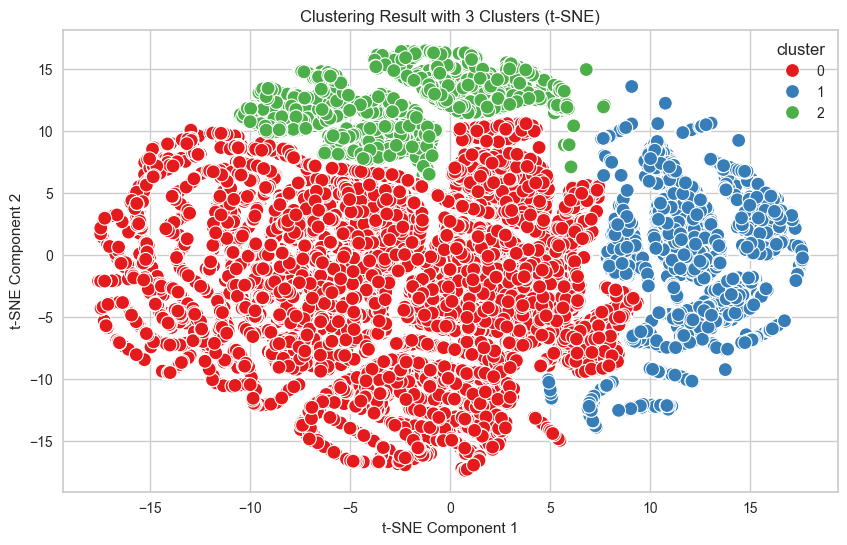

In [486]:
from sklearn.manifold import TSNE

# 데이터 샘플링
sampled_X = pd.DataFrame(X_scaled).sample(frac=0.3, random_state=0)

# PCA로 차원 축소
pca = PCA(n_components=5)
X_pca = pca.fit_transform(sampled_X)

# t-SNE로 차원 축소 (2D)
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=0)
X_tsne = tsne.fit_transform(X_pca)

# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_clust['cluster'].loc[sampled_X.index], palette='Set1', s=100)
plt.title(f'Clustering Result with {optimal_k} Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

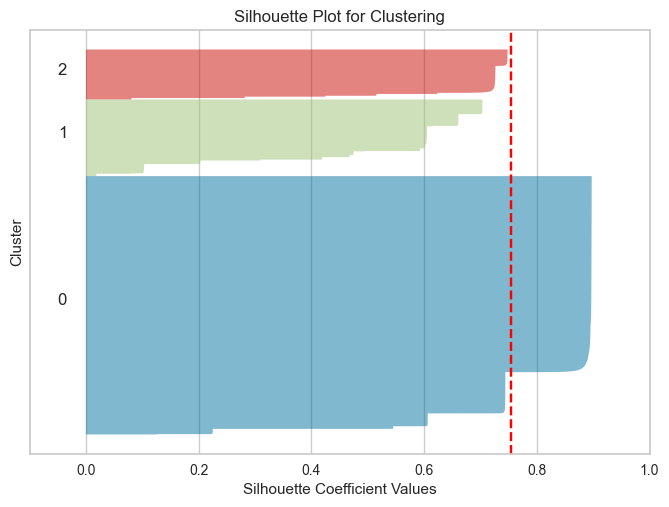

In [487]:
# 각 클러스터의 실루엣 점수 평균 계산
y_lower = 10  # 그래프의 시작 위치

# 클러스터의 고유 값 가져오기
for cluster in np.unique(df_clust['cluster']):
    # 클러스터에 해당하는 인덱스 찾기
    cluster_silhouette_vals = silhouette_vals[df_clust['cluster'] == cluster]
    cluster_silhouette_vals.sort()

    # 클러스터의 실루엣 점수 길이
    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster

    # 클러스터의 실루엣 점수 그리기
    plt.fill_betweenx(np.arange(y_lower, y_upper), cluster_silhouette_vals, alpha=0.5)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
    y_lower = y_upper + 10  # 다음 클러스터의 시작 위치 조정

# 평균 실루엣 점수 선 추가
plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.title('Silhouette Plot for Clustering')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster')
plt.yticks([])  # y축 눈금 제거
plt.xlim(-0.1, 1)  # x축 범위 설정
plt.show()

In [488]:
# customer_id 가 있는 df_agg로 클러스터 결과 복사
df_agg['cluster'] = df_clust['cluster']

In [489]:
# df_agg에서 'customer_id'와 'cluster' 칼럼만 선택하여 병합
df_cleaned = pd.merge(df_cleaned, df_agg[['customer_id', 'cluster']], on='customer_id', how='left')
df_cleaned.columns

Index(['customer_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_timestamp', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'order_item_id', 'product_id', 'seller_id', 'price',
       'shipping_charges', 'product_category_name', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'year_month', 'delivery_time', 'delay_time', 'volume',
       'customer_state_en', 'payment_type_en', 'toy/non-toy',
       'product_category_group', 'product_category_group_en',
       'first_purchase_month', 'order_month', 'signup_month', 'visit_month',
       'purchase_count', 'first_visit_date', 'month', 'first_visit_month',
       'cluster'],
      dtype='object')

In [490]:
# cluster 값을 치환하는 딕셔너리 정의
cluster_mapping = {0: 1, 1: 2, 2: 0}

# cluster 열의 값을 변경
df_cleaned['cluster'] = df_cleaned['cluster'].replace(cluster_mapping)

from mlxtend.frequent_patterns import apriori,association_rules
A = df_cleaned[df_cleaned['cluster']==0]
B = df_cleaned[df_cleaned['cluster']==1]
C = df_cleaned[df_cleaned['cluster']==2]

### ANOVA 검정

In [491]:
# ANOVA 검정 결과를 저장할 리스트
anova_results = []

# cluster 외 모든 칼럼에 대해 ANOVA 검정 수행
for column in df_clust4.columns:
    if column != 'cluster':  # cluster 칼럼은 제외
        # 클러스터를 기준으로 그룹별 데이터 분리
        groups = [group[column].values for name, group in df_clust4.groupby('cluster') if group[column].dtype in ['float64', 'int32', 'int64']]
        
        # ANOVA 검정 수행
        F_statistic, p_value = stats.f_oneway(*groups)
        
        # 결과 저장
        anova_results.append({
            'Column': column,
            'F-statistic': F_statistic,
            'p-value': p_value
        })

# 결과를 데이터프레임으로 변환
anova_df = pd.DataFrame(anova_results)

# ANOVA 결과 데이터프레임 출력
print(anova_df)

                      Column    F-statistic       p-value
0                   order_id       7.451156  5.811166e-04
1                      price     101.432206  9.919585e-45
2           shipping_charges    1071.609700  0.000000e+00
3  product_category_group_en  306336.521031  0.000000e+00
4          customer_state_en  110262.916776  0.000000e+00


In [492]:
# 클러스터별로 고유한 customer_id의 수 계산
unique_customers_per_cluster = (
    df_cleaned
    .groupby('cluster')['customer_id']
    .nunique()  # 고유한 customer_id의 수 계산
    .reset_index(name='unique_customer_count')
)

print(unique_customers_per_cluster)

   cluster  unique_customer_count
0        0                  12079
1        1                  62475
2        2                  18517


In [493]:
# 고객별로 첫 번째 구매 날짜와 구매 횟수를 계산
df_cleaned['purchase_count'] = df_cleaned.groupby('customer_id')['order_purchase_timestamp'].cumcount() + 1

# 두 번 이상 구매한 고객 식별 (동일 날짜 제외)
repeat_customers = df_cleaned[df_cleaned['purchase_count'] > 1].drop_duplicates(subset=['customer_id', 'order_purchase_timestamp'])

# 클러스터별 재구매율 계산
cluster_repeat_rate = repeat_customers.groupby('cluster').agg(
    total_customers=('customer_id', 'nunique')
).reset_index()

# 전체 클러스터별 고객 수 계산
total_customers_by_cluster = df_cleaned.groupby('cluster').agg(
    total_customers=('customer_id', 'nunique')
).reset_index()

# 클러스터별 재구매율 합산
cluster_repeat_rate = cluster_repeat_rate.merge(total_customers_by_cluster, on='cluster', suffixes=('_repeat', '_total'))
cluster_repeat_rate['repeat_rate'] = cluster_repeat_rate['total_customers_repeat'] / cluster_repeat_rate['total_customers_total']

print(cluster_repeat_rate[['cluster', 'repeat_rate']])


   cluster  repeat_rate
0        0     0.141816
1        1     0.143866
2        2     0.176432


### RFM 분석

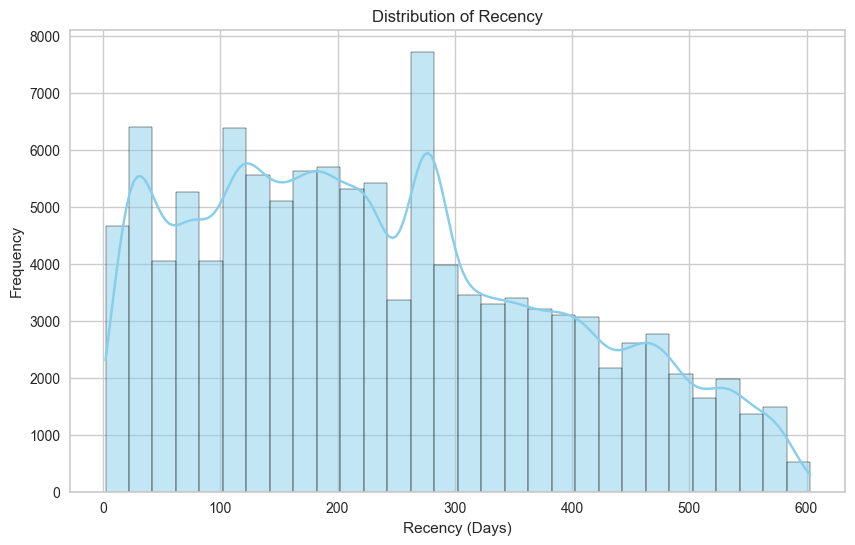

In [494]:
# 'order_purchase_timestamp'를 날짜 형식으로 변환
df_cleaned['order_purchase_timestamp'] = pd.to_datetime(df_cleaned['order_purchase_timestamp'])

# 현재 날짜 또는 분석 시점으로 사용할 날짜 설정
current_date = pd.to_datetime('2018-09-01')  # 분석 시점으로 설정

# 고객별 마지막 구매 날짜 계산
last_purchase_date = df_cleaned.groupby('customer_id')['order_purchase_timestamp'].max().reset_index()

# Recency 계산
last_purchase_date['Recency'] = (current_date - last_purchase_date['order_purchase_timestamp']).dt.days

# Recency 결과를 원래의 df_cleaned에 병합
df_cleaned = df_cleaned.merge(last_purchase_date[['customer_id', 'Recency']], on='customer_id', how='left')

# Recency의 히스토그램
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Recency'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Recency')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency')
plt.show()

In [495]:
# 클러스터별 Recency의 평균 계산
cluster_recency_mean = df_cleaned.groupby('cluster')['Recency'].mean()

# 결과 출력
print("클러스터별 Recency 평균:")
print(cluster_recency_mean)

클러스터별 Recency 평균:
cluster
0    245.886419
1    236.936347
2    238.677268
Name: Recency, dtype: float64


In [496]:

# 고객별 구매 횟수 계산
frequency = df_cleaned.groupby('customer_id').size().reset_index(name='Frequency')

# Frequency 결과를 원래의 df_cleaned에 병합
df_cleaned = df_cleaned.merge(frequency, on='customer_id', how='left')

# 클러스터별 Frequency의 평균 계산
cluster_frequency_mean = df_cleaned.groupby('cluster')['Frequency'].mean()

# 결과 출력
print("클러스터별 Frequency의 평균:")
print(cluster_frequency_mean)

클러스터별 Frequency의 평균:
cluster
0    1.680669
1    1.817078
2    1.707086
Name: Frequency, dtype: float64


In [497]:
import pandas as pd

# 고객별로 price의 합계 계산
customer_total_price = df_cleaned.groupby('customer_id')['price'].sum().reset_index(name='Total_Price')

# Total_Price 결과를 원래의 df_cleaned에 병합
df_cleaned = df_cleaned.merge(customer_total_price, on='customer_id', how='left')

# 클러스터별 Total_Price의 평균 계산
cluster_price_mean = df_cleaned.groupby('cluster')['Total_Price'].mean()

print("클러스터별 Monetary 평균:")
print(cluster_price_mean)


클러스터별 Monetary 평균:
cluster
0    221.598755
1    191.977269
2    171.397001
Name: Total_Price, dtype: float64


### 장바구니 분석

In [498]:
# 다양한 품목은 담은 클러스터2 만 장바구니 분석 진행
from mlxtend.frequent_patterns import apriori, association_rules

# 클러스터 2에 대한 피벗 테이블 생성
basket_C = pd.pivot_table(C, index='order_id', columns='product_category_name',
                          values='product_id', aggfunc='count', fill_value=0)
basket_C = basket_C.applymap(lambda x: 1 if x > 0 else 0)

In [499]:
# confidence를 기준으로 출력 최소 지지도는 0.005%, 신뢰도는 50%로 설정
frequent_itemsets_C_confidence = apriori(basket_C, min_support=0.00005, use_colnames=True)
rules_C_confidence = association_rules(frequent_itemsets_C_confidence, metric="confidence", min_threshold=0.5) 
print("Cluster C Market Basket Analysis (Lift):\n", rules_C_confidence)

c:\Users\pyj66\AppData\Local\Programs\Python\Python38\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Cluster C Market Basket Analysis (Lift):
                                   antecedents              consequents  \
0                       (luggage_accessories)  (computers_accessories)   
1           (construction_tools_construction)          (health_beauty)   
2                                     (music)              (perfumery)   
3                (housewares, bed_bath_table)                   (toys)   
4                          (toys, cine_photo)              (telephony)   
5                     (telephony, cine_photo)                   (toys)   
6       (garden_tools, computers_accessories)                   (toys)   
7  (home_construction, computers_accessories)                   (toys)   
8              (furniture_decor, electronics)                   (toys)   

   antecedent support  consequent support   support  confidence       lift  \
0            0.000103            0.095732  0.000052         0.5   5.222940   
1            0.000052            0.141922  0.000052         1